# STAT3009 Project 1
- LAW Yiu Leung Eric    1155149315
- LAM Wai Chiu          1155152095
- Tsoi Tung Sing        1155127274

## Import packages and load the developed methods

In [1]:
import numpy as np
import pandas as pd

from developed_methods import *

## Pre-process the raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- create `train_pair`,`train_rating`, `test_pair`

In [2]:
dtrain = pd.read_csv("data/train.csv")
dtest = pd.read_csv("data/test.csv")

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

Create train_pair, train_rating and test_pair

In [3]:
# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

# Exploratory Data Analysis (EDA)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Summary of the Dataset

In [5]:
print("Number of users: {n_user}\nNumber of items: {n_item}".format(n_user = n_user, n_item = n_item))
print("Number of records (rows): {n_rows}".format(n_rows = len(dtrain)))

Number of users: 492
Number of items: 959
Number of records (rows): 15303


The target variable is `rating`, which is discrete within [0, 15]. The explanatory variables are `user_id` and `item_id`, they are both nominal categorical data.

## Histogram of Ratings

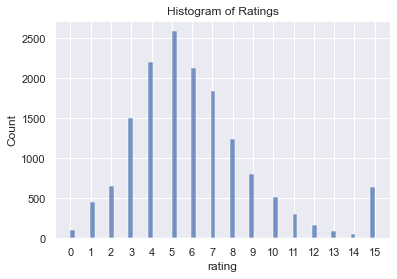

In [6]:
g = sns.histplot(data=dtrain, x="rating")
g.set_title("Histogram of Ratings")
g.set_xticks(range(0, 15+1))
plt.show(g)

The mode of rating is 5

## Histogram of Users and Items


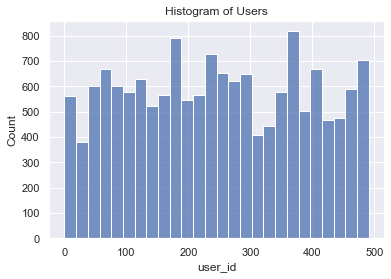

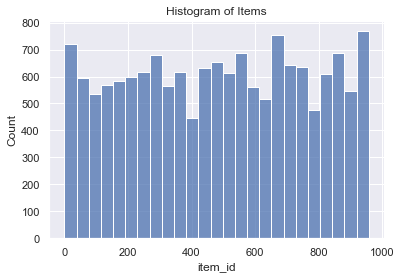

In [7]:
# histogram of users
g = sns.histplot(data = dtrain, x = "user_id")
g.set_title("Histogram of Users")
plt.show(g)

# histogram of items
g = sns.histplot(data = dtrain, x = "item_id")
g.set_title("Histogram of Items")
plt.show(g)

## Histogram for Averaged Ratings for Users and Items

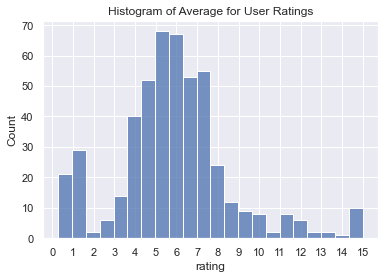

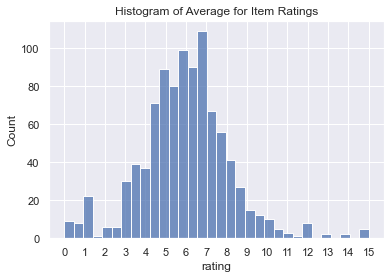

In [8]:
# Histogram of average for user ratings
g = sns.histplot(x = dtrain.groupby("user_id")["rating"].mean())
g.set_xticks(range(15+1))
g.set_title("Histogram of Average for User Ratings")
plt.show(g)

# Histogram of average for item ratings
g = sns.histplot(x = dtrain.groupby("item_id")["rating"].mean())
g.set_xticks(range(15+1))
g.set_title("Histogram of Average for Item Ratings")
plt.show(g)

## Find Top-20 highest Rating Items
Calculate the average rating of each items, then find the top 20

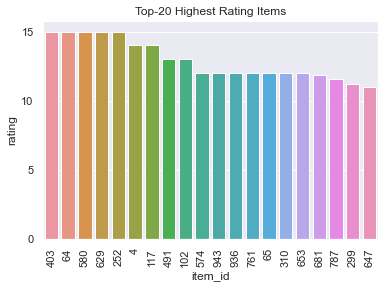

In [9]:
top20_item = dtrain.groupby("item_id")["rating"].mean().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Highest Rating Items")
g.set_yticks(range(0, 15+1, 5))
g.tick_params(axis = "x", rotation = 90)
plt.show(g)

## Find Top-20 Most Popular Items
Count the number of ratings of each items, then find the top 20

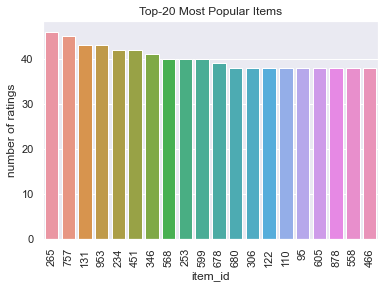

In [10]:
top20_item = dtrain.groupby("item_id")["rating"].count().sort_values(ascending = False)[:20]
g = sns.barplot(x = top20_item.index, y = top20_item, order = top20_item.index)
g.set(title = "Top-20 Most Popular Items", ylabel = "number of ratings")
g.tick_params(axis='x', rotation=90)
plt.show(g)

# Impelement deep learning with Keras

In [11]:
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## Create the model
We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.

In [12]:
class LFactorNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(LFactorNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        concatted_vec = self.concatenate([user_vector, movie_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [46]:
## Baseline + NCF
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pair)

# item_mean
train_rating_res -=  user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

train_rating_res -= item_ave.predict(train_pair)

In [47]:
model = LFactorNet(num_users=n_user, num_items=n_item, embedding_size=100)


metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

callbacks = [keras.callbacks.EarlyStopping( 
    monitor='val_rmse', min_delta=0, patience=5, verbose=1, 
    mode='auto', baseline=None, restore_best_weights=True)]

history = model.fit(
    x=train_pair,
    y=train_rating_res,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=.2,
)

Epoch 1/20
192/192 [==============================] - 2s 4ms/step - loss: 2.0256 - mae: 0.9021 - rmse: 1.1630 - val_loss: 1.3702 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3534 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 3/20
192/192 [==============================] - 1s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 5/20
192/192 [==============================] - 0s 3ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 1.3523 - mae: 0.9019 - rmse: 1.1629 - val_loss: 1.3628 - val_mae: 0.9002 - val_rmse: 1.1674
Epoc

In [48]:
train_pred_rating = glb_ave.predict(train_pair) + user_ave.predict(train_pair) + item_ave.predict(train_pair) + model.predict(train_pair).flatten()
rmse(train_rating, train_pred_rating)

1.1637926707361146

## Make prediction

In [16]:
pred_rating = pred + model.predict(test_pair).flatten()
pred_rating = np.array(pred_rating)
print(pred_rating)

[2.48521862 4.77526723 4.7357608  ... 3.62452553 9.98011706 4.5890244 ]


## Adjust the prediction within [0, 15]

In [17]:
def adjust(pred_rating, score_min, score_max):
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[pred_rating > score_max] = score_max
    pred_rating_adjusted[pred_rating < score_min] = score_min
    return pred_rating_adjusted

# Result
## Save to csv with timestamp

In [64]:
pred_rating = adjust(pred_rating, 0, 15)

from datetime import datetime
nowTime = datetime.now().strftime("%Y-%m-%d_%H-%M")

method = "glb_user_item_NCF"
fileName = "predict/{method}_{nowTime}.csv".format(method = method, nowTime = nowTime)

submit = pd.DataFrame({"id": range(len(dtest)), "rating": pred_rating})
submit.to_csv(fileName, index = False)

## Print T-th record

In [65]:
t = 9315
t = 315 # there are only 3826 rows in test.csv, change t to 315

print("T-th test_pair: ", test_pair[t])
print("T-th predicted rating: ", pred_rating[t])

T-th test_pair:  [124 103]
T-th predicted rating:  1.892751620991472


## Print Top-5 Preferred Items based on `pred_rating`

In [66]:
user_id_t = test_pair[t, 0]
index = dtest[dtest["user_id"] == user_id_t].index
pred_t = pd.DataFrame({"item_id": dtest["item_id"][index], "rating": pred_rating[index]})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
2521,952,6.356096
2687,178,4.913444
2350,947,4.799069
255,96,4.774183
1678,295,4.392175


## Print Top-5 Preferred Items (including items may not been seen by the user)

In [67]:
test_pair_t = np.array([[user_id_t, item] for item in range(n_item)])
pred_rating_t = glb_ave.predict(test_pair_t) + user_ave.predict(test_pair_t) + item_ave.predict(test_pair_t) + model.predict(test_pair_t).flatten()
pred_t = pd.DataFrame({"item_id": range(n_item), "rating": adjust(pred_rating_t, 0, 15)})
pred_t.sort_values("rating", ascending = False, inplace = True)
pred_t[:5]

,item_id,rating
252,252,13.160800
117,117,12.661375
4,4,12.101098
653,653,10.993568
943,943,10.805256
